# Importing Dependencies

In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

# Loading and Visualising the data

Found 202599 files.


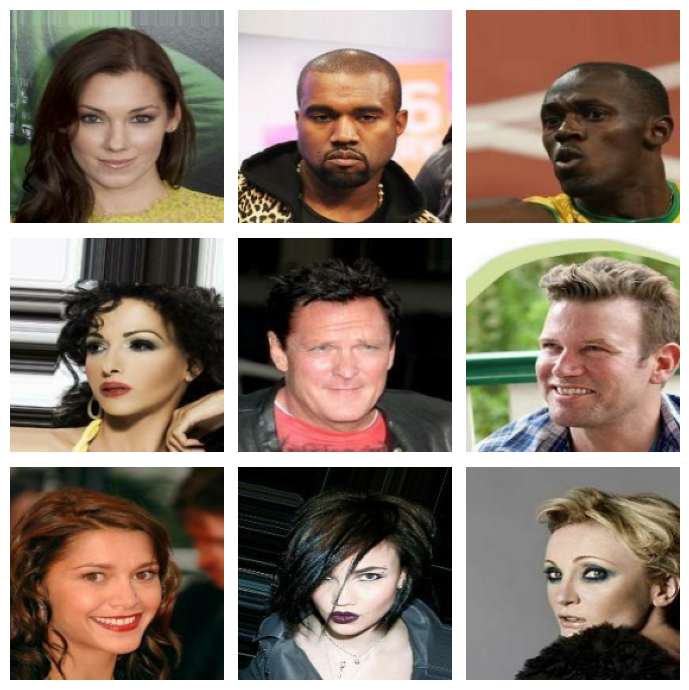

In [81]:
BATCH_SIZE = 128
IMG_HEIGHT = 180
IMG_WIDTH = 180

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory="/Users/abdulbari/Downloads/img_align_celeba",
    seed=42,
    label_mode=None,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=True
)

import random

total_batches = tf.data.experimental.cardinality(dataset=dataset).numpy()
rand_batch_index = random.randint(0, total_batches-1)

plt.figure(figsize=(7, 7))
for images in dataset.skip(rand_batch_index).take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    rand_img_index = random.randint(0, BATCH_SIZE-1)
    plt.imshow(images[rand_img_index].numpy().astype("uint8"))
    plt.axis(False)

plt.tight_layout()
plt.show()

# Data Preprocessing

In [82]:
def preprocess_images(dataset):
    dataset = dataset.map(lambda image: tf.cast(image, tf.float32) / 255.0)
    dataset = dataset.take(2**14)
    dataset = dataset.cache()
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    dataset = dataset.repeat()
    print(dataset.as_numpy_iterator().next()[0].shape)

preprocess_images(dataset)

2024-11-01 11:51:22.026668: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


(128, 180, 180, 3)


# Generator

In [88]:
def build_generator():
    generator = tf.keras.Sequential([

        tf.keras.layers.Dense(128*45*45, input_shape=[128], activation="leaky_relu"),
        tf.keras.layers.Reshape((45,45,128)),

        tf.keras.layers.UpSampling2D(),
        tf.keras.layers.Conv2D(128, 7, padding="same", activation="leaky_relu"),

        tf.keras.layers.UpSampling2D(),
        tf.keras.layers.Conv2D(128, 7, padding="same", activation="leaky_relu"),
        
        tf.keras.layers.Conv2D(128, 7, padding="same", activation="leaky_relu"),

        tf.keras.layers.Conv2D(64, 7, padding="same", activation="leaky_relu"),

        tf.keras.layers.Conv2D(32, 7, padding="same", activation="leaky_relu"),

        tf.keras.layers.Conv2D(16, 7, padding="same", activation="leaky_relu"),

        tf.keras.layers.Conv2D(3, 7, padding="same", activation="sigmoid")

    ])
    return generator

gen = build_generator()
gen.summary()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 259200)         │    33,436,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_12 (Reshape)            │ (None, 45, 45, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_23 (UpSampling2D) │ (None, 90, 90, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_84 (Conv2D)              │ (None, 90, 90, 128)    │       802,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_24 (UpSampling2D) │ (None, 180, 180, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_85 (Conv2D)              │ (None, 180, 180, 128)  │       802,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_86 (Conv2D)              │ (None, 180, 180, 128)  │       802,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_87 (Conv2D)              │ (None, 180, 180, 64)   │       401,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_88 (Conv2D)              │ (None, 180, 180, 32)   │       100,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_89 (Conv2D)              │ (None, 180, 180, 16)   │        25,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_90 (Conv2D)              │ (None, 180, 180, 3)    │         2,355 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,374,947 (138.76 MB)

 Trainable params: 36,374,947 (138.76 MB)

 Non-trainable params: 0 (0.00 B)

# Visualising Untrained Generated Images

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 515ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step


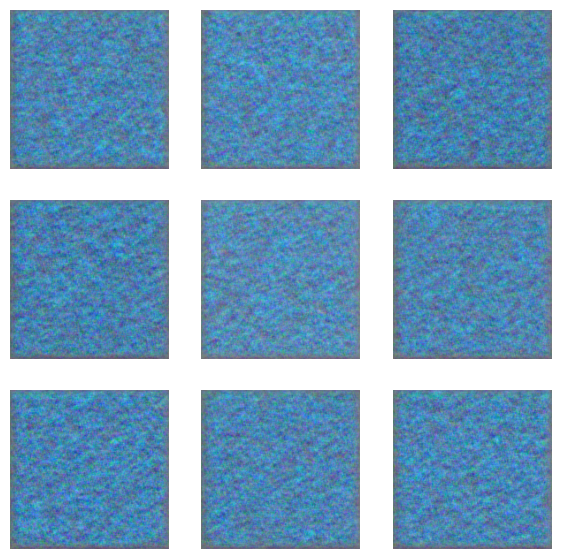

In [100]:
plt.figure(figsize=(7,7))
for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    img = gen.predict(np.random.randn(1,128))
    # Normalize to [0,1] range for visualization
    img = (img - img.min()) / (img.max() - img.min())
    plt.imshow(np.squeeze(img))
    plt.axis(False)

# Discriminator

In [90]:
def build_discriminator():
    discriminator = tf.keras.Sequential([

        tf.keras.layers.Conv2D(128, 10, input_shape=[180,180,3], padding="same", activation="leaky_relu"),
        tf.keras.layers.Dropout(0.4),
        
        tf.keras.layers.Conv2D(256, 10, padding="same", activation="leaky_relu"),
        tf.keras.layers.Dropout(0.4),

        tf.keras.layers.Conv2D(192, 10, padding="same", activation="leaky_relu"),
        tf.keras.layers.Dropout(0.4),
        
        tf.keras.layers.Conv2D(128, 10, padding="same", activation="leaky_relu"),
        tf.keras.layers.Dropout(0.4),
        
        tf.keras.layers.Conv2D(64, 10, padding="same", activation="leaky_relu"),
        tf.keras.layers.Dropout(0.4),
        
        tf.keras.layers.Conv2D(32, 10, padding="same", activation="leaky_relu"),

        tf.keras.layers.Dropout(0.4),
        
        tf.keras.layers.Conv2D(16, 10, padding="same", activation="leaky_relu"),
        tf.keras.layers.Dropout(0.4),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(1, activation="sigmoid")
    ])
    return discriminator

disc = build_discriminator()
disc.summary()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_91 (Conv2D)              │ (None, 180, 180, 128)  │        38,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 180, 180, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_92 (Conv2D)              │ (None, 180, 180, 256)  │     3,277,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 180, 180, 256)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_93 (Conv2D)              │ (None, 180, 180, 192)  │     4,915,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 180, 180, 192)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_94 (Conv2D)              │ (None, 180, 180, 128)  │     2,457,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 180, 180, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_95 (Conv2D)              │ (None, 180, 180, 64)   │       819,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 180, 180, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_96 (Conv2D)              │ (None, 180, 180, 32)   │       204,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 180, 180, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_97 (Conv2D)              │ (None, 180, 180, 16)   │        51,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 180, 180, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 518400)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 518400)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1)              │       518,401 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,282,417 (46.85 MB)

 Trainable params: 12,282,417 (46.85 MB)

 Non-trainable params: 0 (0.00 B)